<h1><center>CS 513 Knowledge Discovery and Data Mining</center></h1>
<h1><center>Multiclass Object Classification in Autonomous Driving</center></h1>
<h3>Group Members</h3>
<h4>Bhushan Asati</h4>
<h4>Suyash Madhavi</h4>
<h4>Anirudh Sharma</h4>
<h4>Rujuta Dabke</h4>

Multiclass Object Classification using the KITTI Dataset Models in this script:

- InceptionV3
- DenseNet121

This script includes:

1) Kaggle API setup and dataset download
2) Data Loading and Preprocessing
3) Training the models
4) Evaluating the models
5) Annotating outputs

In [1]:
!pip install tensorflow_addons tensorflow_hub shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.7 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
import random
import pandas as pd
from sklearn.preprocessing import label_binarize

# Kaggle API Setup and Dataset Download

1. **Upload Kaggle API Key**:
   - The `kaggle.json` file contains your Kaggle credentials.
   - Upload it to Colab using the `files.upload()` method.

In [ ]:
from google.colab import files
files.upload()

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p /root/.config/kaggle/
!mv ~/.kaggle/kaggle.json /root/.config/kaggle/

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# 2) Data Loading and Preprocessing

1. **Dataset Download**:
   - Download the KITTI dataset using the Kaggle API.
   - Extract the dataset into image and label directories.

2. **Simplifying Categories**:
   - Map original KITTI classes to two categories: `Human` (e.g., Pedestrian, Cyclist) and `Vehicle` (e.g., Car, Truck).
   - Ignore irrelevant classes (`Misc`, `DontCare`).

3. **Image and Label Processing**:
   - Resize images to `224x224`, normalize, and convert to RGB.
   - Map labels to simplified categories.

4. **Data Splitting**:
   - Split data into training, validation, and test sets with balanced class proportions.

5. **Handling Class Imbalance**:
   - Compute class weights to mitigate imbalance during model training.

6. **Data Augmentation**:
   - Apply augmentation (rotation, flipping, zooming) to the training data.

In [12]:
dataset_name = 'garymk/kitti-3d-object-detection-dataset'
dataset_path = '/content/kitti_dataset/'

In [13]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    !kaggle datasets download -d {dataset_name} -p {dataset_path}
    !unzip -q {dataset_path}kitti-3d-object-detection-dataset.zip -d {dataset_path}
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/garymk/kitti-3d-object-detection-dataset
License(s): unknown
100% 30.0G/30.0G [09:43<00:00, 19.0MB/s]
100% 30.0G/30.0G [09:43<00:00, 55.2MB/s]
Dataset downloaded and extracted successfully.


In [14]:
image_dir = os.path.join(dataset_path, 'training/image_2/')
label_dir = os.path.join(dataset_path, 'training/label_2/')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

In [15]:
# Mapping original classes to simplified classes
class_mapping = {
    'Pedestrian': 'Human',
    'Person_sitting': 'Human',
    'Cyclist': 'Human',
    'Car': 'Vehicle',
    'Truck': 'Vehicle',
    'Van': 'Vehicle',
    'Tram': 'Vehicle',
    'Misc': None,       # Exclude
    'DontCare': None    # Exclude
}


In [16]:
def map_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        mapped_classes = []
        for line in lines:
            data = line.strip().split()
            obj_class = data[0]
            mapped_class = class_mapping.get(obj_class)
            if mapped_class is not None:
                mapped_classes.append(mapped_class)
        return mapped_classes

In [17]:
TARGET_SIZE = (224, 224)
images = []
labels = []

In [18]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace('.png', '.txt'))

    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, TARGET_SIZE)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    mapped_classes = map_label(label_path)
    if mapped_classes and len(mapped_classes) > 0:
        images.append(image_rgb)
        labels.append(mapped_classes[0])
    else:
        # Skip images with no valid label
        continue

X = np.array(images, dtype=np.float32)
y = np.array(labels)

In [19]:
X = X / 255.0  # Normalize

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = list(label_encoder.classes_)
print("Reduced Categories:", class_names)  # Should be ["Human", "Vehicle"]

Reduced Categories: ['Human', 'Vehicle']


In [20]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [21]:
# Class weights to handle imbalance
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {}
for class_idx, count in class_counts.items():
    class_weights[class_idx] = total_samples / (len(class_names) * count)

print("Class Weights:", class_weights)


Class Weights: {1: 0.5847665847665847, 0: 3.449275362318841}


In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator()


# 3) Training the models

1. **Data Preparation**:
   - Data is augmented for training and normalized for validation/testing.
   - Class weights are calculated to handle any class imbalance.

2. **Model Architectures**:
   - **DenseNet121**:
     - Pretrained on ImageNet with the last 10 layers unfrozen for fine-tuning.
     - Includes custom Dense layers for classification.
   - **InceptionV3**:
     - Pretrained on ImageNet with the last 20 layers unfrozen for fine-tuning.
     - Includes custom Dense layers for classification.


In [23]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

In [24]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_gen = test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_gen = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
def plot_training_history(history, title_suffix=""):
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Model Loss {title_suffix}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Model Accuracy {title_suffix}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def evaluate_model(model, test_gen, y_test, title_suffix=""):
    # Evaluate
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"Test Accuracy {title_suffix}: {test_acc*100:.2f}%")

    # Predictions
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(f"Classification Report {title_suffix}:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Per-class metrics
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    metrics_df.plot(x="Class", kind="bar", figsize=(10,6))
    plt.title(f"Per-Class Performance Metrics {title_suffix}")
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.legend(loc="lower right")
    plt.show()

    # ROC Curve
    n_classes = len(class_names)
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))
    if y_test_binarized.shape[1] == 1 and n_classes > 1:
        y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.title(f"ROC Curves {title_suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Sample predictions
    num_samples = 10
    indices = random.sample(range(len(X_test)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    y_pred_full = np.argmax(model.predict(X_test), axis=1) # Predict without gen if needed

    for i, ax in enumerate(axes.flatten()):
        idx = indices[i]
        ax.imshow(X_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_full[idx]]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
from tensorflow.keras.applications import DenseNet121

print("Training DenseNet121...")
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
densenet_base.trainable = True
for layer in densenet_base.layers[:-10]:
    layer.trainable = False

model_densenet = models.Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


Training DenseNet121...
29084464/29084464 [==============================] - 0s 0us/step


# 4) Evaluate and Annotate the models

1. **Compilation**:
   - Optimizer: Adam (`learning_rate=1e-4`).
   - Loss: `sparse_categorical_crossentropy`.
   - Metric: Accuracy.

2. **Training and Evaluation**:
   - Both models are trained for 10 epochs using training and validation data.
   - Models are evaluated using:
     - Accuracy and loss curves.
     - Classification reports and confusion matrices.
     - ROC curves and sample predictions.


In [28]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_densenet = model_densenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
164/164 [==============================] - 125s 720ms/step - loss: 0.4175 - accuracy: 0.8371 - val_loss: 0.2938 - val_accuracy: 0.8966
Epoch 2/10
164/164 [==============================] - 111s 675ms/step - loss: 0.2739 - accuracy: 0.9043 - val_loss: 0.1923 - val_accuracy: 0.9394
Epoch 3/10
164/164 [==============================] - 106s 648ms/step - loss: 0.1973 - accuracy: 0.9280 - val_loss: 0.1025 - val_accuracy: 0.9626
Epoch 4/10
164/164 [==============================] - 113s 686ms/step - loss: 0.1596 - accuracy: 0.9396 - val_loss: 0.1116 - val_accuracy: 0.9626
Epoch 5/10
164/164 [==============================] - 110s 671ms/step - loss: 0.1342 - accuracy: 0.9515 - val_loss: 0.1693 - val_accuracy: 0.9456
Epoch 6/10
164/164 [==============================] - 111s 677ms/step - loss: 0.0989 - accuracy: 0.9658 - val_loss: 0.0846 - val_accuracy: 0.9742
Epoch 7/10
164/164 [==============================] - 107s 652ms/step - loss: 0.0881 - accuracy: 0.9679 - val_loss: 0.0674 -

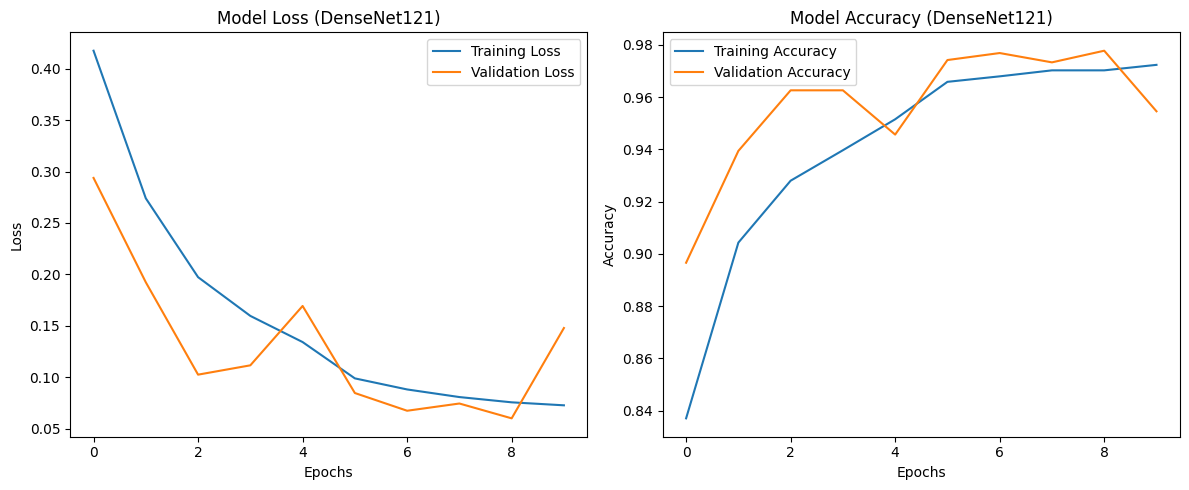

Test Accuracy (DenseNet121): 95.55%
36/36 [==============================] - 21s 524ms/step
Classification Report (DenseNet121):
              precision    recall  f1-score   support

       Human       0.77      0.99      0.87       163
     Vehicle       1.00      0.95      0.97       960

    accuracy                           0.96      1123
   macro avg       0.88      0.97      0.92      1123
weighted avg       0.96      0.96      0.96      1123



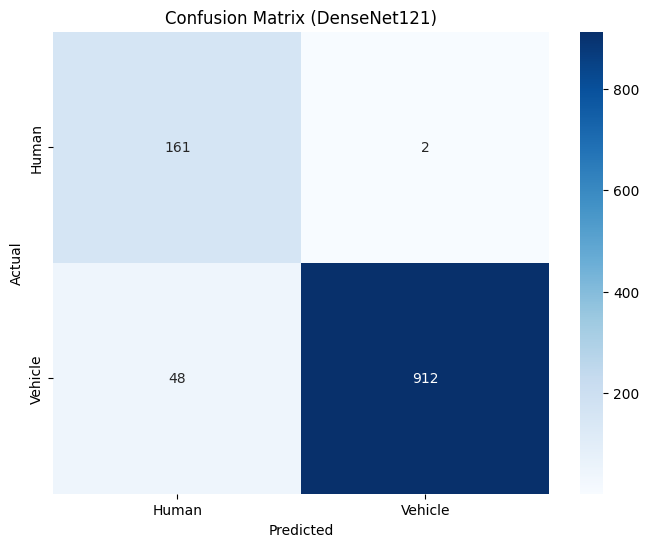

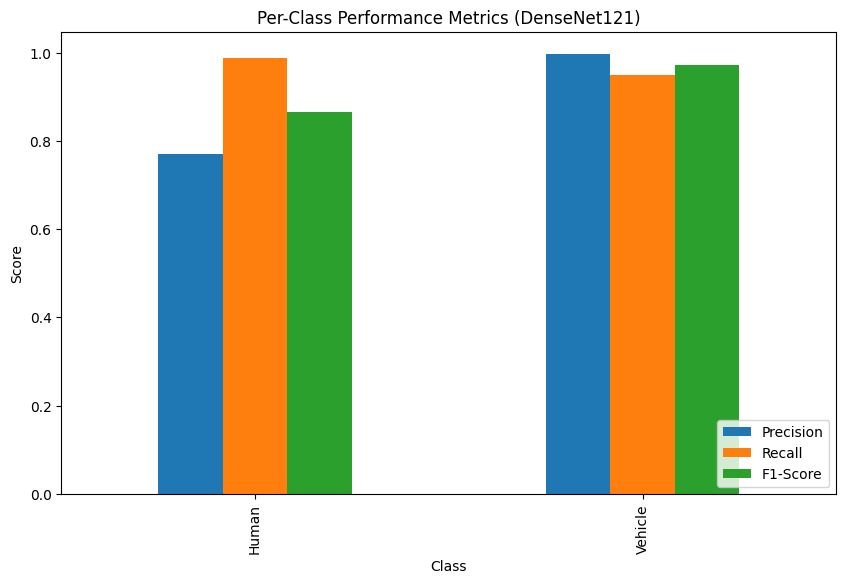

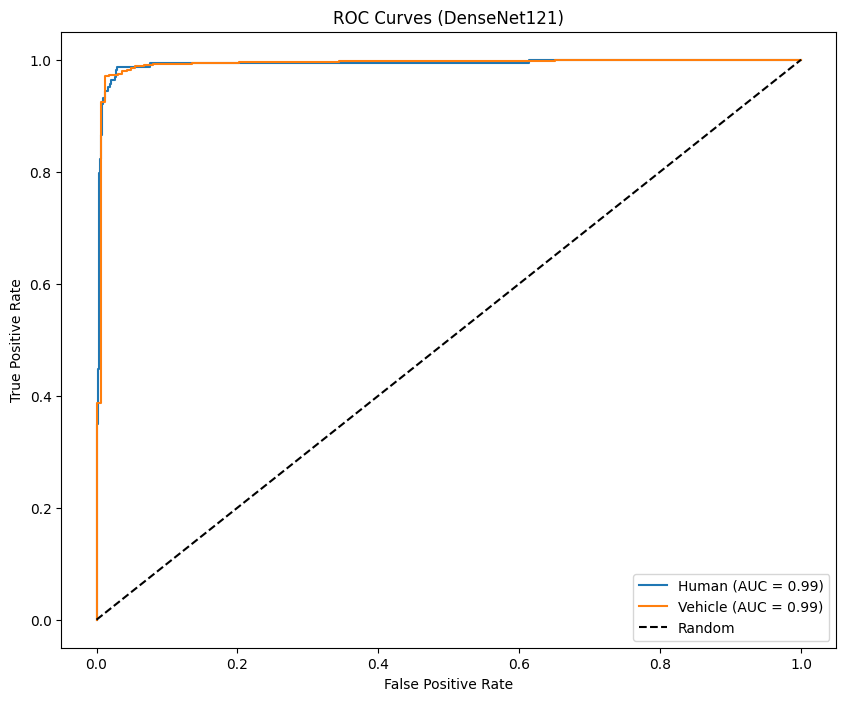

36/36 [==============================] - 21s 528ms/step


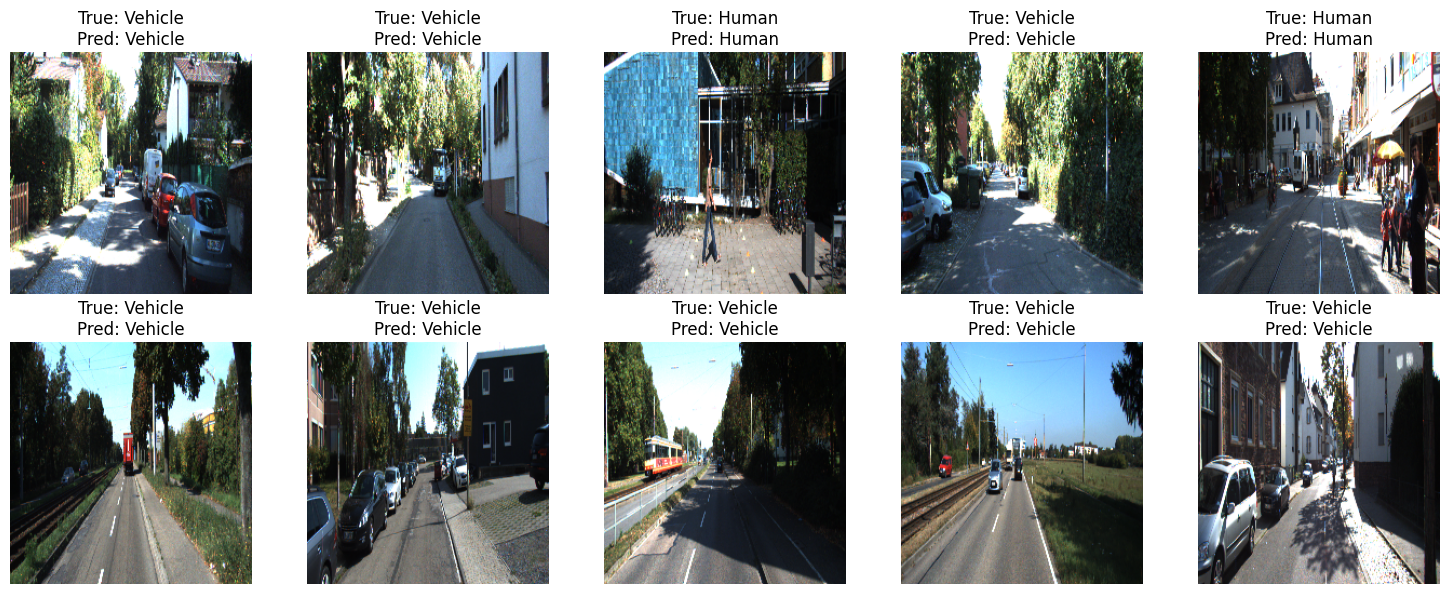

In [29]:
plot_training_history(history_densenet, title_suffix="(DenseNet121)")
evaluate_model(model_densenet, test_gen, y_test, title_suffix="(DenseNet121)")

In [30]:
from tensorflow.keras.applications import InceptionV3

print("Training InceptionV3...")
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
inception_base.trainable = True
for layer in inception_base.layers[:-20]:
    layer.trainable = False

model_inception = models.Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

Training InceptionV3...
87910968/87910968 [==============================] - 0s 0us/step


In [31]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

history_inception = model_inception.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
164/164 [==============================] - 76s 434ms/step - loss: 0.3306 - accuracy: 0.8814 - val_loss: 0.2017 - val_accuracy: 0.9323
Epoch 2/10
164/164 [==============================] - 69s 423ms/step - loss: 0.2082 - accuracy: 0.9261 - val_loss: 0.1628 - val_accuracy: 0.9412
Epoch 3/10
164/164 [==============================] - 70s 425ms/step - loss: 0.1772 - accuracy: 0.9349 - val_loss: 0.1154 - val_accuracy: 0.9626
Epoch 4/10
164/164 [==============================] - 70s 428ms/step - loss: 0.1508 - accuracy: 0.9482 - val_loss: 0.1140 - val_accuracy: 0.9608
Epoch 5/10
164/164 [==============================] - 70s 424ms/step - loss: 0.1283 - accuracy: 0.9578 - val_loss: 0.0925 - val_accuracy: 0.9661
Epoch 6/10
164/164 [==============================] - 70s 425ms/step - loss: 0.1176 - accuracy: 0.9576 - val_loss: 0.0830 - val_accuracy: 0.9670
Epoch 7/10
164/164 [==============================] - 70s 424ms/step - loss: 0.0969 - accuracy: 0.9647 - val_loss: 0.1219 - val_ac

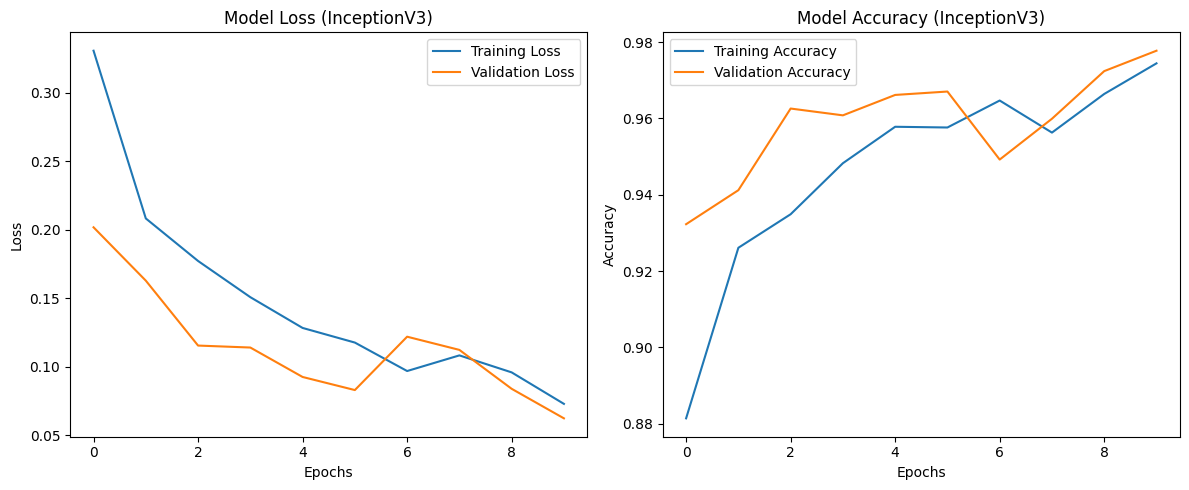

Test Accuracy (InceptionV3): 97.68%
36/36 [==============================] - 8s 173ms/step
Classification Report (InceptionV3):
              precision    recall  f1-score   support

       Human       0.92      0.93      0.92       163
     Vehicle       0.99      0.99      0.99       960

    accuracy                           0.98      1123
   macro avg       0.95      0.96      0.95      1123
weighted avg       0.98      0.98      0.98      1123



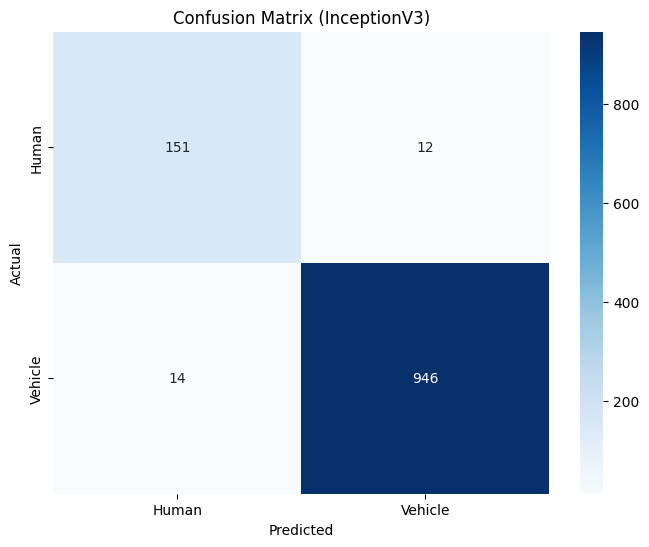

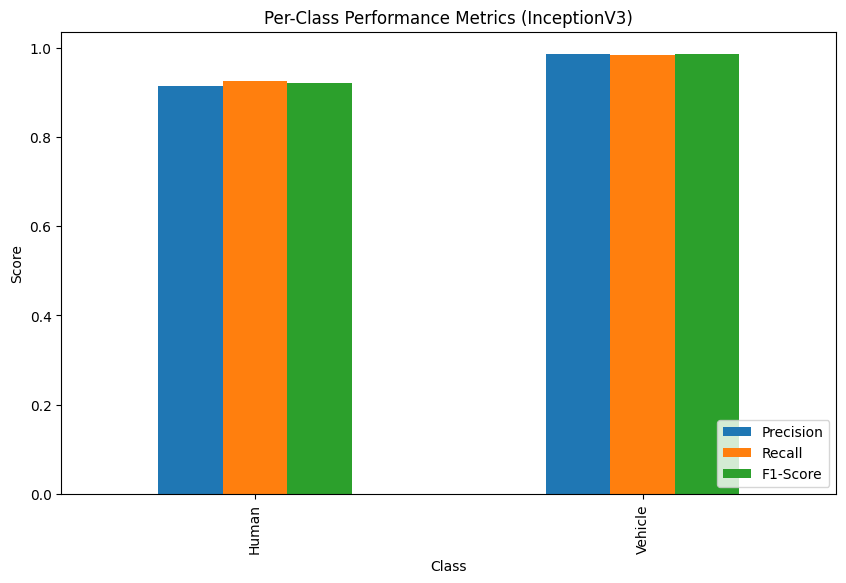

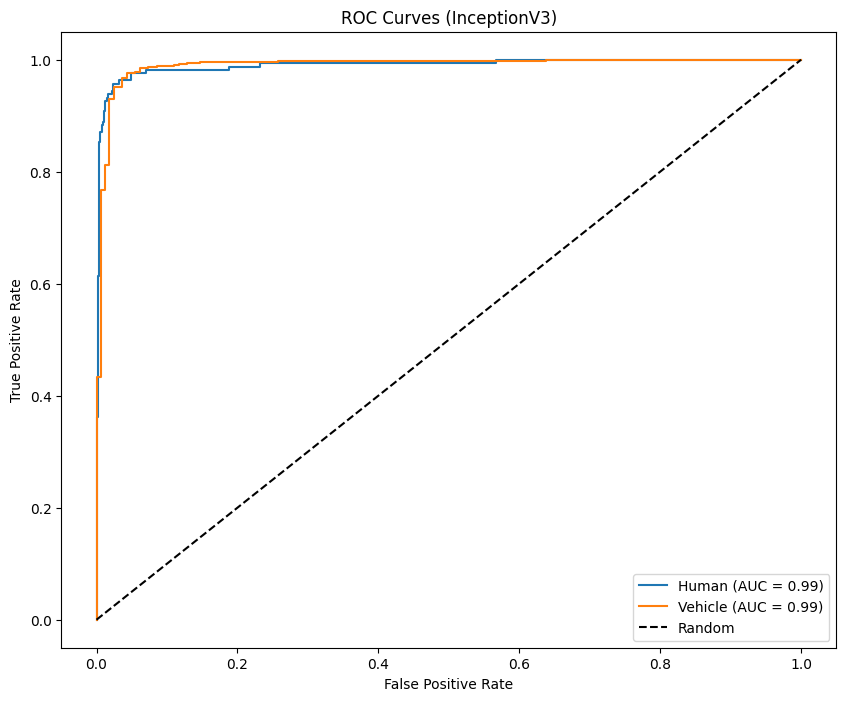

36/36 [==============================] - 8s 174ms/step


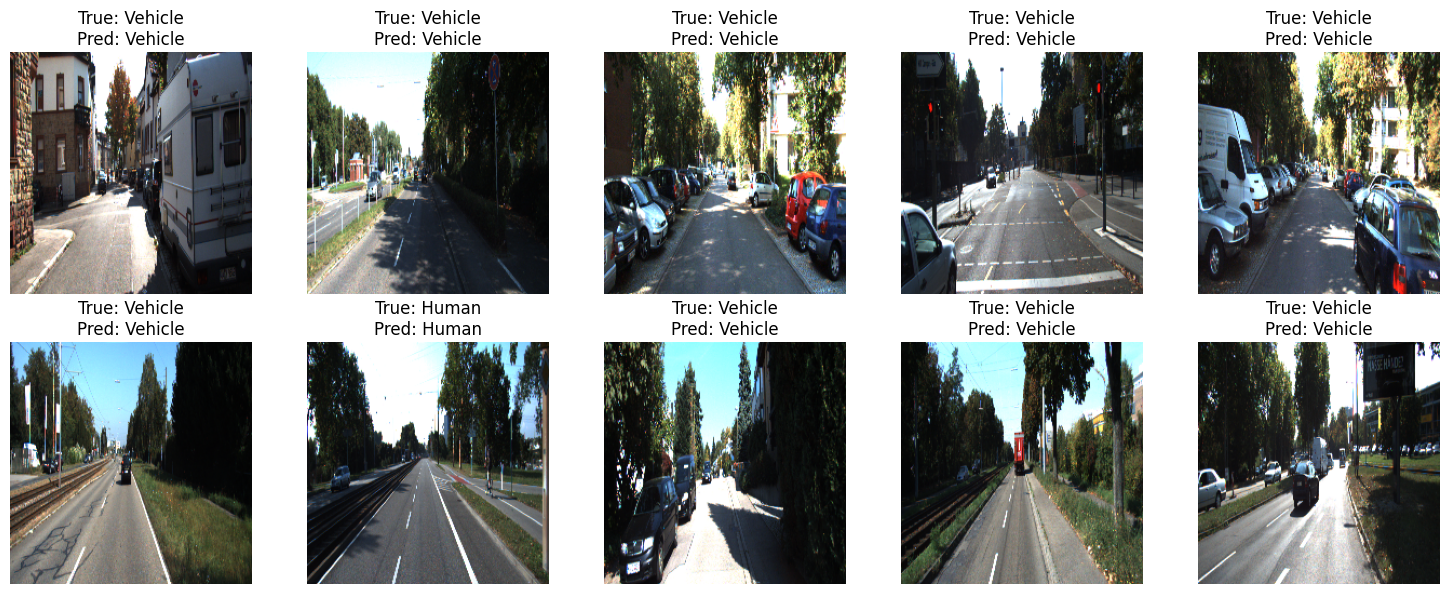

In [32]:
plot_training_history(history_inception, title_suffix="(InceptionV3)")
evaluate_model(model_inception, test_gen, y_test, title_suffix="(InceptionV3)")